In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from scipy.stats import mode
import joblib
import matplotlib.pyplot as plt



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [3]:
predictions = []

### Loading Datasets

In [4]:
# Check if the file is open
if os.access("spam.csv", os.R_OK):
    data = pd.read_csv("spam.csv", encoding='ISO-8859-1')
else:
    print("File is open or you don't have permission to access it.")
data = pd.read_csv("spam.csv", encoding='ISO-8859-1')


In [5]:
# Check if the file is open
if os.access("mail_data.csv", os.R_OK):
    data2 = pd.read_csv("mail_data.csv", encoding='ISO-8859-1')
else:
    print("File is open or you don't have permission to access it.")
data2 = pd.read_csv("mail_data.csv", encoding='ISO-8859-1')#Read the CSV file


In [6]:
# Check if the file is open
if os.access("Spam-Classification.csv", os.R_OK):
    data3 = pd.read_csv("Spam-Classification.csv", encoding='ISO-8859-1')
else:
    print("File is open or you don't have permission to access it.")
data3 = pd.read_csv("Spam-Classification.csv", encoding='ISO-8859-1')#Read the CSV file


In [7]:
print(data.tail())


        v1                                                 v2 Unnamed: 2  \
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  


In [8]:
print(data2.tail())

     Category                                            Message
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham              Will Ã¼ b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name


In [9]:
print(data3.tail())

     ï»¿Class                                                SMS
1495      ham       Yup, no need. I'll jus wait 4 e rain 2 stop.
1496      ham  Yup... From what i remb... I think should be c...
1497      ham                         Yup... How ÃÂ¼ noe leh...
1498      ham  Yup... Ok i go home look at the timings then i...
1499     spam  <Forwarded from 21870000>Hi - this is your Mai...


In [10]:
print(data2.isnull().sum())

Category    0
Message     0
dtype: int64


In [11]:
print(data.isnull().sum())

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [12]:
print(data3.isnull().sum())

ï»¿Class    0
SMS         0
dtype: int64


In [13]:
# Combine the 'v1' and 'Category' into a single labels Series
y = pd.concat([data['v1'], data2['Category'],data3['ï»¿Class']], ignore_index=True)

# Combine the 'v2' and 'Message' into a single messages Series
X = pd.concat([data['v2'], data2['Message'],data3['SMS']], ignore_index=True)

X,y

(0        Go until jurong point, crazy.. Available only ...
 1                            Ok lar... Joking wif u oni...
 2        Free entry in 2 a wkly comp to win FA Cup fina...
 3        U dun say so early hor... U c already then say...
 4        Nah I don't think he goes to usf, he lives aro...
                                ...                        
 12639         Yup, no need. I'll jus wait 4 e rain 2 stop.
 12640    Yup... From what i remb... I think should be c...
 12641                           Yup... How ÃÂ¼ noe leh...
 12642    Yup... Ok i go home look at the timings then i...
 12643    <Forwarded from 21870000>Hi - this is your Mai...
 Length: 12644, dtype: object,
 0         ham
 1         ham
 2        spam
 3         ham
 4         ham
          ... 
 12639     ham
 12640     ham
 12641     ham
 12642     ham
 12643    spam
 Length: 12644, dtype: object)

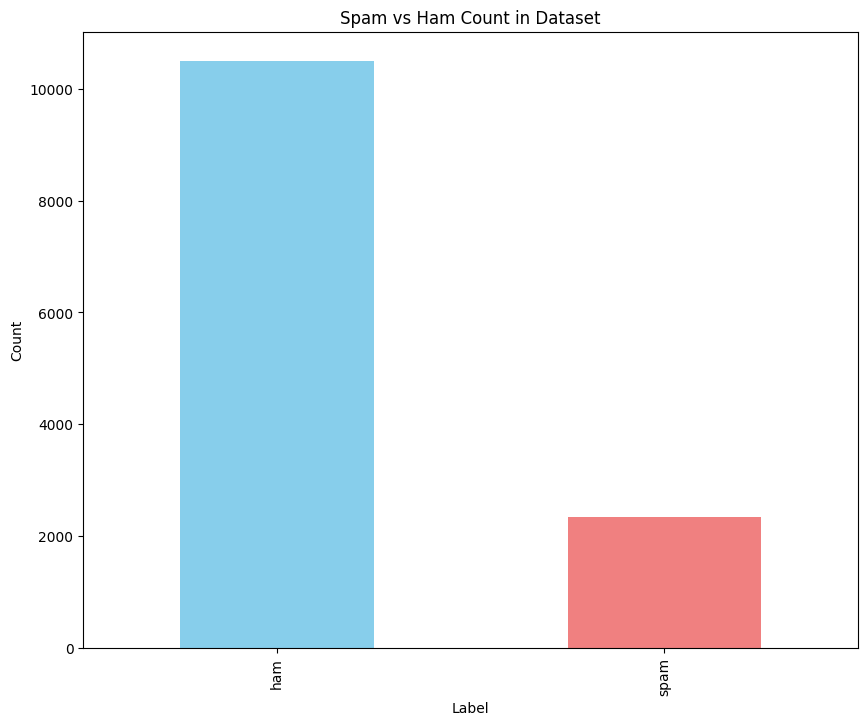

In [14]:

label_counts = data['v1'].value_counts() + data2['Category'].value_counts()+data3['ï»¿Class'].value_counts()+100

plt.figure(figsize=(10,8))
label_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])

plt.title('Spam vs Ham Count in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

### Preparing Training and Testing Data

In [15]:
# Changing the labels from 'ham' and 'spam' to 0 and 1
y=LabelEncoder().fit_transform(y)


In [16]:
# Splitting the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Converting the messages into numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()
X_train_tfidf, X_test_tfidf 

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

### Using Deep Learning

In [18]:
# Converting everything to tensors for PyTorch
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

X_train_tensor ,y_train_tensor ,X_test_tensor ,y_test_tensor

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0.],
         [0.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [1.]]))

In [19]:

X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

In [20]:
class SpamClassifier(nn.Module):
    def __init__(self, input_size):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  
        self.bn1 = nn.BatchNorm1d(256)         
        self.fc2 = nn.Linear(256, 128)         
        self.bn2 = nn.BatchNorm1d(128)         
        self.fc3 = nn.Linear(128, 64)          
        self.bn3 = nn.BatchNorm1d(64)          
        self.fc4 = nn.Linear(64, 32)           
        self.dropout = nn.Dropout(0.5)         
        self.fc5 = nn.Linear(32, 1)            
        self.sigmoid = nn.Sigmoid()           

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  
        x = torch.relu(self.bn2(self.fc2(x)))  
        x = self.dropout(x)                     
        x = torch.relu(self.bn3(self.fc3(x)))  
        x = self.dropout(x)                    
        x = self.sigmoid(self.fc5(self.fc4(x)))  
        return x


In [21]:
# Creating the model and putting it on the GPU if it's available
model = SpamClassifier(input_size=X_train_tfidf.shape[1]).to(device)

In [22]:
# Setting up binary cross-entropy as the loss function and Adam as the optimizer
lossfn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [299]:
"""# Training loop: runs for 2500 epochs
num_epochs = 2500
for epoch in range(num_epochs):
    model.train()  # Making sure the model is in training mode
    for inputs, labels in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True):
        # Forward pass: making predictions
        outputs = model(inputs)
        loss = lossfn(outputs, labels)
        
        # Backward pass: calculating gradients and updating weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')"""

"# Training loop: runs for 2500 epochs\nnum_epochs = 2500\nfor epoch in range(num_epochs):\n    model.train()  # Making sure the model is in training mode\n    for inputs, labels in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True):\n        # Forward pass: making predictions\n        outputs = model(inputs)\n        loss = lossfn(outputs, labels)\n        \n        # Backward pass: calculating gradients and updating weights\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')"

In [24]:
# Evaluation: testing the model on the test set
model.eval()  # Switch to evaluation mode
with torch.no_grad():  # No need to calculate gradients during evaluation
    test_outputs = model(X_test_tensor)
    test_outputs = (test_outputs > 0.5).float()  # Convert probabilities to binary predictions
    accuracydl = (test_outputs == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracydl * 100:.5f}%')
    predictions.append(test_outputs.squeeze().cpu().numpy())

    

Test Accuracy: 99.80229%


In [25]:
def makepreds(text):
    
    # The text must be wrapped in a list to transform it properly
    vector = vectorizer.transform([text])
    
    # Move the input to tensor and GPU if available
    input_tensor = torch.tensor(vector.toarray(), dtype=torch.float32).to(device)
    
    # Make sure the model is in evaluation mode
    model.eval()
    
    # Predict the output
    with torch.no_grad():
        prediction = model(input_tensor)
    
    # Convert the prediction to binary (0 or 1) based on a threshold
    return "spam" if prediction.item() > 0.5 else "ham"

In [26]:
makepreds("WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.")

'spam'

In [143]:
"""# Specify the path where the model will be saved
model_save_path = "spam_classifier_model.pth"

# Save the model's state dictionary (this contains the trained parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")"""

'# Specify the path where the model will be saved\nmodel_save_path = "spam_classifier_model.pth"\n\n# Save the model\'s state dictionary (this contains the trained parameters)\ntorch.save(model.state_dict(), model_save_path)\n\nprint(f"Model saved to {model_save_path}")'

In [23]:
# Initialize the same model architecture
model = SpamClassifier(input_size=X_train_tfidf.shape[1])

# Load the state dictionary (trained parameters) into the model
model.load_state_dict(torch.load("spam_classifier_model.pth"))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Ezaz\AppData\Local\Temp\ipykernel_18036\2702470331.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("spam_classifier_model.pth")

### Using Logistic Regression

In [27]:
#Training the model
model = LogisticRegression()

In [28]:
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [29]:
#Accuracy for the training data
prediction_on_training_data = model.predict(X_train_tfidf)
accuracy_on_training_data = accuracy_score(y_train, prediction_on_training_data)
prediction_on_training_data 

#Printing the accuracy for the training data
print('Accuracy on training data: ', accuracy_on_training_data)

Accuracy on training data:  0.9875432525951557


In [30]:
#Accuracy for the test data
prediction_on_test_data = model.predict(X_test_tfidf)
accuracy_on_test_datalr = accuracy_score(y_test, prediction_on_test_data)

#Printing the accuracy for the test data
print('Accuracy on test data: ', accuracy_on_test_datalr)
predictions.append(prediction_on_test_data)

joblib.dump(model, 'LogisticR_model.pkl')

Accuracy on test data:  0.9829972321075524


['LogisticR_model.pkl']

### Using SVM

In [31]:
# Step 4: Train an SVM classifier
svm_model = SVC(kernel='linear')  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [32]:
# Step 5: Make predictions and evaluate
y_pred = svm_model.predict(X_test_tfidf)


In [33]:
# Calculate accuracy
accuracysvm = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracysvm:.2f}')
predictions.append(y_pred)
joblib.dump(svm_model, 'svm_model.pkl')

Accuracy: 0.99


['svm_model.pkl']

### Random Forest

In [34]:
# Step 4: Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

In [35]:
# Step 5: Make predictions and evaluate
y_pred = rf_model.predict(X_test_tfidf)

In [36]:
# Calculate accuracy
accuracyrf = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracyrf:.2f}')
predictions.append(y_pred)
joblib.dump(rf_model, 'rf_model.pkl')

Accuracy: 1.00


['rf_model.pkl']

### Descision Tree

In [37]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)





DecisionTreeClassifier(random_state=42)

In [38]:

# Step 5: Make predictions and evaluate
y_pred = dt_model.predict(X_test_tfidf)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [39]:
# Calculate accuracy
accuracydt = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracydt:.2f}')
predictions.append(y_pred)
joblib.dump(dt_model, 'dt_model.pkl')

Accuracy: 1.00


['dt_model.pkl']

### Using Ensamble


In [40]:
# Combine predictions using majority voting
predictions= np.array(predictions)
from collections import Counter

# Manually compute mode for each column
result = []
for col in predictions.T:  # Transpose to iterate over columns
    count = Counter(col)  # Count occurrences
    most_common_value = count.most_common(1)[0][0]  # Get the most common value
    result.append(most_common_value)

ensemble_pred = np.array(result)  # Convert the result back to a numpy array


accuracye = accuracy_score(y_test, ensemble_pred)
print(f'Ensemble Accuracy: {accuracye:.4f}')


Ensemble Accuracy: 0.9980


### Comparing Results


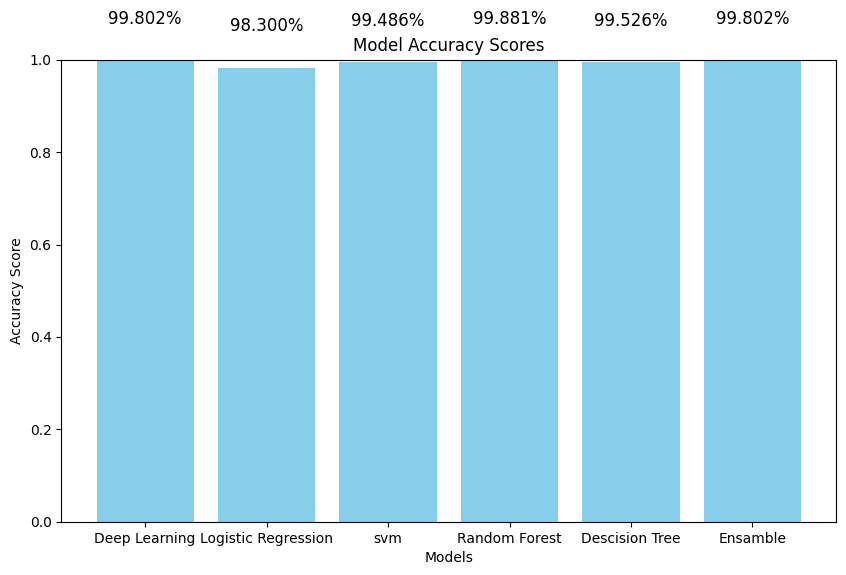

In [41]:
import matplotlib.pyplot as plt

# Example data
models = ['Deep Learning', 'Logistic Regression','svm','Random Forest','Descision Tree','Ensamble']  # Replace with your model names
accuracy_scores = [accuracydl, accuracy_on_test_datalr,accuracysvm,accuracyrf,accuracydt,accuracye] # Replace with your accuracy scores

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(models, accuracy_scores, color='skyblue')  # Create bars

# Add title and labels
plt.title('Model Accuracy Scores')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1

# Add accuracy scores on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.07, f'{(score*100):.3f}%', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()
